# Finetuning RoBerta for Token Classification 
 



https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForTokenClassification

***

## Imports

In [1]:
#!pip install transformers
!pip install datasets
!pip install seqeval
#!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 374.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ec74cf385d6f9651097c8b72280f3c46e34e29bb2aee8b99b74b40d106899500
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [5]:
from transformers import (BertTokenizerFast,
                          RobertaTokenizerFast,
                          BertForTokenClassification,
                          RobertaForTokenClassification,
                          DataCollatorForTokenClassification, 
                          AutoModelForTokenClassification, 
                          TrainingArguments, Trainer)
from datasets import load_dataset, concatenate_datasets
import torch
import os

## Use Pretrained Model

**Load Model ans Tokenizer:**

https://huggingface.co/bert-base-multilingual-cased

In [6]:
model_name = "xlm-roberta-large" #"bert-base-multilingual-cased" #xlm-roberta-large
tokenizer = RobertaTokenizerFast.from_pretrained(f"{model_name}", add_prefix_space=True) #AutoTokenizer(use_fast = True)
#model = RobertaForTokenClassification.from_pretrained(f"{model_name}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMRobertaTokenizerFast'. 
The class this function is called from is 'RobertaTokenizerFast'.


In [4]:
model.config

RobertaConfig {
  "_name_or_path": "xlm-roberta-large",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

**Predict Labels:**

Since Bloom has not been fintuned for Token Classification yet, the prediction is poor as expected.

In [5]:
text = "Für Richard Phillips Feynman war es immer wichtig, die unanschaulichen Gesetzmäßigkeiten der Quantenphysik Laien und Studenten nahezubringen und verständlich zu machen."

inputs = tokenizer(
    text, add_special_tokens=False, return_tensors="pt"
)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_token_class_ids = logits.argmax(-1)

# Note that tokens are classified rather then input words which means that
# there might be more predicted token classes than words.
# Multiple token classes might account for the same word
predicted_tokens_classes = [model.config.id2label[t.item()] for t in predicted_token_class_ids[0]]
print(predicted_tokens_classes)

['LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0', 'LABEL_0']


## Download Dataset for Finetuning

See:
* Dataset on Huggingface: https://huggingface.co/datasets/wikiann
* Load Datasets: https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/loading_methods

In [6]:
# Specify list of languages
languages = ["en","de"]
#languages = ["en"]
dataset_name = "wikiann"

# Downloa first language
dataset_train = load_dataset(dataset_name, languages[0],  split="train")
dataset_valid = load_dataset(dataset_name, languages[0],  split="validation")
dataset_test =  load_dataset(dataset_name, languages[0],  split="test")
languages.pop(0)

# Merge with additional languages
for language in languages:
    
    print(f"Download Dataset for Language {language}")
    
    # Combine train splits
    dataset_train_new = load_dataset(dataset_name, language,  split="train")
    dataset_train = concatenate_datasets([dataset_train, dataset_train_new])

    # Combine validation splits
    dataset_valid_new = load_dataset(dataset_name, language,  split="validation")
    dataset_valid = concatenate_datasets([dataset_valid, dataset_valid_new])
    
    # Combine test splits
    dataset_test_new = load_dataset(dataset_name, language,  split="test")
    dataset_test = concatenate_datasets([dataset_test, dataset_test_new])

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/en/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.
Download Dataset for Language de


Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/de/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


**Limit Dataset Size for Testing:**

In [7]:
## Sample a subset of datapoints
#num_samples = 1000
#sample_ids = list(range(0,num_samples))
#
## Reduce the size of the dataset
#dataset_train = dataset_train.select(sample_ids)
#dataset_valid = dataset_valid.select(sample_ids)
#dataset_test = dataset_test.select(sample_ids)
#
#print("Training Examples:", len(dataset_train))

### About the Dataset:

**Splits:**

In [8]:
dataset_train

Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'spans'],
    num_rows: 40000
})

**Training Examples:**

In [9]:
print("Dataset Object Type:", type(dataset_train))
print("Training Examples:", len(dataset_train))

Dataset Object Type: <class 'datasets.arrow_dataset.Dataset'>
Training Examples: 40000


**Sample Structure:**

In [10]:
dataset_train[95]

{'tokens': ['Bruce', 'Beresford', '(', 'Non-Jew', ')'],
 'ner_tags': [1, 2, 0, 0, 0],
 'langs': ['en', 'en', 'en', 'en', 'en'],
 'spans': ['PER: Bruce Beresford']}

**Class Labels:**

In [11]:
label_list = dataset_train.features[f"ner_tags"].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

## Tokenize Dataset

### Tokenize a Single Sample:

In [12]:
example = dataset_train[0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True, add_special_tokens= False)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

['▁R', '.', 'H', '.', '▁Sa', 'under', 's', '▁(', '▁St', '.', '▁Lawrence', '▁River', '▁)', '▁(', '▁9', '68', '▁MW', '▁)']


Sample after Tokenization:

In [13]:
tokenized_input

{'input_ids': [627, 5, 841, 5, 947, 24658, 7, 15, 2907, 5, 155484, 32547, 1388, 15, 483, 16028, 46298, 1388], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Word IDs:

In [14]:
tokenized_input.word_ids()

[0, 0, 0, 0, 1, 1, 1, 2, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10]

### Tokenize Whole Dataset

In [15]:
def tokenizeInputs(inputs):
    
    tokenized_inputs = tokenizer(inputs["tokens"], max_length = 512, truncation=True, is_split_into_words=True, add_special_tokens= False)
    word_ids = tokenized_inputs.word_ids()
    ner_tags = inputs["ner_tags"]
    labels = [ner_tags[word_id] for word_id in word_ids]
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

In [16]:
example = dataset_train[100]
tokenizeInputs(example)

{'input_ids': [32036, 111, 5369, 23, 30089], 'attention_mask': [1, 1, 1, 1, 1], 'labels': [3, 4, 4, 4, 4]}

In [17]:
tokenized_dataset_train = dataset_train.map(tokenizeInputs)
tokenized_dataset_valid = dataset_valid.map(tokenizeInputs)
tokenized_dataset_test =  dataset_test.map(tokenizeInputs)

  0%|          | 0/40000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/20000 [00:00<?, ?ex/s]

**Shuffle Dataset:**

In [18]:
tokenized_dataset_train = tokenized_dataset_train.shuffle()
tokenized_dataset_valid = tokenized_dataset_valid.shuffle()
tokenized_dataset_test =  tokenized_dataset_test.shuffle()

**Count of Tokens in the Training Set:**

In [19]:
token_count = 0
for sample in tokenized_dataset_train:
    token_count = token_count + len(sample["labels"])
    
print("Tokens in Training Set:", token_count)

Tokens in Training Set: 556022


**Remove unnecessary columns:**

In [20]:
tokenized_dataset_train = tokenized_dataset_train.remove_columns(["tokens", "ner_tags", "langs", "spans"])
tokenized_dataset_valid = tokenized_dataset_valid.remove_columns(["tokens", "ner_tags", "langs", "spans"])
tokenized_dataset_test = tokenized_dataset_test.remove_columns(["tokens", "ner_tags", "langs", "spans"])

## Define Data Collator

In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Define Trainer

In [22]:
import gc
gc.collect()
torch.cuda.empty_cache()

Load Model Class which can be finetuned:

In [23]:
label_list = dataset_train.features[f"ner_tags"].feature.names

In [24]:
model = AutoModelForTokenClassification.from_pretrained(f"{model_name}", num_labels=len(label_list)).cuda()

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-

About the Model:

see https://github.com/huggingface/transformers/blob/v4.21.1/src/transformers/modeling_utils.py#L829

In [25]:
print("Parameters:", model.num_parameters())
print("Expected Input Dict:", model.main_input_name )

# Estimate FLOPS needed for one training example
sample = tokenized_dataset_train[0]
sample["input_ids"] = torch.Tensor(sample["input_ids"])
flops_est = model.floating_point_ops(input_dict = sample, exclude_embeddings = False)

print("FLOPS needed per Training Sample:", flops_est )

Parameters: 558848007
Expected Input Dict: input_ids
FLOPS needed per Training Sample: 124064257554


**Define Optimizer:**

See https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.Adafactor

In [26]:
#from transformers.optimization import Adafactor, AdafactorSchedule

#optimizer = Adafactor(    
#        model.parameters(),
#        lr=1e-3,
#        eps=(1e-30, 1e-3),
#        clip_threshold=1.0,
#        decay_rate=-0.8,
#        beta1=None,
#        weight_decay=0.0,
#        relative_step=False,
#        scale_parameter=False,
#        warmup_init=False,
#    )

#lr_scheduler = AdafactorSchedule(optimizer)

**Define Metrics:**

See https://huggingface.co/course/chapter7/2#metrics

In [27]:
from datasets import load_metric
metric = load_metric("seqeval")

In [28]:
example = dataset_train[150]
labels = [label_list[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [29]:
label_names = dataset_train.features[f"ner_tags"].feature.names

id2label = {id : label for id, label in enumerate(label_names)}
label2id = {label: id for id, label in enumerate(label_names)}

model.config.id2label = id2label
model.config.label2id = label2id

In [30]:
label_names = model.config.id2label

In [31]:
import numpy as np

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    true_labels = [[label_names[l] for l in label  if l != -100] for label in labels]
    #true_predictions = [model.config.id2label[t.item()] for t in predictions]
    
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label)  if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    
    print(results)
    
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

**Set further Training Arguments:**

See https://huggingface.co/docs/transformers/v4.21.2/en/main_classes/trainer#transformers.TrainingArguments

In [32]:
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy= "no",# "epoch",
    #save_steps = 2000,
    remove_unused_columns = True,
    evaluation_strategy="steps",
    eval_steps = 2000,
    #load_best_model_at_end=True,
    logging_strategy = "steps",
    logging_steps = 2000,
    learning_rate= 2e-5,
    auto_find_batch_size = True,
    #per_device_train_batch_size=8,
    #per_device_eval_batch_size=8,
    #gradient_accumulation_steps=4,
    #optim="adamw_torch",
    num_train_epochs=5,
    weight_decay=0.01,
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    #optimizers=(optimizer, lr_scheduler),
    compute_metrics=compute_metrics
)

Using cuda_amp half precision backend


## Train Model

GPU used by Kaggle: https://www.nvidia.com/de-de/data-center/tesla-p100/

In [33]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Mon Sep  5 15:11:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/

In [34]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/accelerate/memory_utils.py:26: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25000


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
2000,0.494400,0.332519,0.760188,0.776118,0.768070,0.905558


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.7878856215046004, 'recall': 0.8293690357498932, 'f1': 0.8080952931652596, 'number': 21063}, 'ORG': {'precision': 0.6790288315629742, 'recall': 0.6591444732500589, 'f1': 0.6689389182886357, 'number': 16972}, 'PER': {'precision': 0.8079387094643683, 'recall': 0.8350740664891801, 'f1': 0.8212823094998322, 'number': 14649}, 'overall_precision': 0.7601881460548822, 'overall_recall': 0.7761179864854605, 'overall_f1': 0.7680704786234879, 'overall_accuracy': 0.9055584546452414}


***** Running training *****
  Num examples = 40000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50000


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
2000,0.341400,0.326344,0.779977,0.797965,0.788869,0.916528
4000,0.347500,0.357393,0.800316,0.808139,0.804208,0.920328
6000,0.317700,0.365493,0.781430,0.807342,0.794174,0.919357
8000,0.312900,0.306104,0.804261,0.808215,0.806233,0.919986
10000,0.294000,0.310273,0.832311,0.839230,0.835756,0.933460
12000,0.222700,0.326742,0.829538,0.840198,0.834834,0.932870
14000,0.236900,0.317290,0.840634,0.840730,0.840682,0.935533
16000,0.217200,0.280376,0.839006,0.848227,0.843592,0.936872
18000,0.215700,0.292337,0.852200,0.849062,0.850628,0.938679
20000,0.211100,0.287928,0.854635,0.856598,0.855615,0.940788


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8449354317998385, 'recall': 0.7952333475763187, 'f1': 0.8193313278059041, 'number': 21063}, 'ORG': {'precision': 0.6753048780487805, 'recall': 0.7569526278576479, 'f1': 0.7138015335037227, 'number': 16972}, 'PER': {'precision': 0.8267224769118331, 'recall': 0.8494095160079186, 'f1': 0.8379124579124579, 'number': 14649}, 'overall_precision': 0.7799773650717082, 'overall_recall': 0.7979652266342723, 'overall_f1': 0.7888687689406378, 'overall_accuracy': 0.916527810267576}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.7745759920961633, 'recall': 0.8933200398803589, 'f1': 0.829721089185316, 'number': 21063}, 'ORG': {'precision': 0.7627857803620985, 'recall': 0.680179118548197, 'f1': 0.7191179218837601, 'number': 16972}, 'PER': {'precision': 0.8869527336092354, 'recall': 0.8339135777186156, 'f1': 0.8596157905847583, 'number': 14649}, 'overall_precision': 0.8003157954096881, 'overall_recall': 0.8081390934629109, 'overall_f1': 0.8042084187263299, 'overall_accuracy': 0.9203282169398809}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8545954758508254, 'recall': 0.7963727864026967, 'f1': 0.8244574967437517, 'number': 21063}, 'ORG': {'precision': 0.6814985832721167, 'recall': 0.7652604289417865, 'f1': 0.720954759922287, 'number': 16972}, 'PER': {'precision': 0.8111781517942204, 'recall': 0.8718683869206089, 'f1': 0.8404290320457986, 'number': 14649}, 'overall_precision': 0.7814296999871397, 'overall_recall': 0.8073418874800699, 'overall_f1': 0.7941744853661953, 'overall_accuracy': 0.9193565220520756}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8470689408055038, 'recall': 0.8417604329867541, 'f1': 0.8444063437633949, 'number': 21063}, 'ORG': {'precision': 0.6942718753290513, 'recall': 0.7769856233796841, 'f1': 0.7333036756937108, 'number': 16972}, 'PER': {'precision': 0.8959133507451221, 'recall': 0.7961635606526043, 'f1': 0.8430982759243866, 'number': 14649}, 'overall_precision': 0.8042611865591296, 'overall_recall': 0.8082150178422292, 'overall_f1': 0.8062332547549395, 'overall_accuracy': 0.9199863242941716}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8578538536676125, 'recall': 0.875611261453734, 'f1': 0.8666416051877261, 'number': 21063}, 'ORG': {'precision': 0.7707822131785266, 'recall': 0.7588380862597219, 'f1': 0.7647635165226687, 'number': 16972}, 'PER': {'precision': 0.8644226900898485, 'recall': 0.880060072359888, 'f1': 0.8721712952000812, 'number': 14649}, 'overall_precision': 0.8323105304770152, 'overall_recall': 0.8392301267937134, 'overall_f1': 0.8357560062756365, 'overall_accuracy': 0.9334604934050708}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8543111069750128, 'recall': 0.8716707021791767, 'f1': 0.8629036048315083, 'number': 21063}, 'ORG': {'precision': 0.753637190270516, 'recall': 0.7813457459344804, 'f1': 0.7672413793103448, 'number': 16972}, 'PER': {'precision': 0.8858063612161973, 'recall': 0.8631305891187112, 'f1': 0.87432147425924, 'number': 14649}, 'overall_precision': 0.8295384269410243, 'overall_recall': 0.8401981626300205, 'overall_f1': 0.8348342684709321, 'overall_accuracy': 0.932870278732478}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8613382899628252, 'recall': 0.8800265869059488, 'f1': 0.8705821571988821, 'number': 21063}, 'ORG': {'precision': 0.7693836978131213, 'recall': 0.7752769267028046, 'f1': 0.7723190702588484, 'number': 16972}, 'PER': {'precision': 0.8955786181404606, 'recall': 0.8600587070789815, 'f1': 0.8774593446390638, 'number': 14649}, 'overall_precision': 0.8406338963750237, 'overall_recall': 0.8407296332852479, 'overall_f1': 0.8406817621045038, 'overall_accuracy': 0.9355334424990553}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8659077124061028, 'recall': 0.8811185491145611, 'f1': 0.8734469126506025, 'number': 21063}, 'ORG': {'precision': 0.764941378324278, 'recall': 0.7880626914918689, 'f1': 0.7763299184490815, 'number': 16972}, 'PER': {'precision': 0.8890902753572674, 'recall': 0.870639634104717, 'f1': 0.8797682279092226, 'number': 14649}, 'overall_precision': 0.8390064397424103, 'overall_recall': 0.84822716574292, 'overall_f1': 0.8435916071243169, 'overall_accuracy': 0.9368722221222536}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.874236180190422, 'recall': 0.8762284574846888, 'f1': 0.8752311850903399, 'number': 21063}, 'ORG': {'precision': 0.7852932594105632, 'recall': 0.7928352580721187, 'f1': 0.7890462368428768, 'number': 16972}, 'PER': {'precision': 0.9000280819994384, 'recall': 0.8751450610963206, 'f1': 0.8874121759595751, 'number': 14649}, 'overall_precision': 0.8522004191274528, 'overall_recall': 0.8490623339154202, 'overall_f1': 0.8506284823245288, 'overall_accuracy': 0.9386788548395804}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8737570857726977, 'recall': 0.8927977970849357, 'f1': 0.8831748268169544, 'number': 21063}, 'ORG': {'precision': 0.7944560357675112, 'recall': 0.7852345038887579, 'f1': 0.7898183542240792, 'number': 16972}, 'PER': {'precision': 0.895850565205404, 'recall': 0.8872277971192573, 'f1': 0.8915183317899648, 'number': 14649}, 'overall_precision': 0.8546349777483193, 'overall_recall': 0.8565978285627515, 'overall_f1': 0.8556152774222906, 'overall_accuracy': 0.9407877926331132}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8741556398630518, 'recall': 0.8970232160660875, 'f1': 0.8854418070623522, 'number': 21063}, 'ORG': {'precision': 0.8030048076923076, 'recall': 0.7872967240160264, 'f1': 0.7950731881470903, 'number': 16972}, 'PER': {'precision': 0.9015288394718555, 'recall': 0.8855894600314015, 'f1': 0.8934880677709288, 'number': 14649}, 'overall_precision': 0.8591482410151204, 'overall_recall': 0.8584959380457065, 'overall_f1': 0.8588219656691477, 'overall_accuracy': 0.9414247926151188}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}


***** Running Evaluation *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8745312282976063, 'recall': 0.8967858329772587, 'f1': 0.8855187286109417, 'number': 21063}, 'ORG': {'precision': 0.8018206863508415, 'recall': 0.7888286589677115, 'f1': 0.7952716148385757, 'number': 16972}, 'PER': {'precision': 0.9009302971396834, 'recall': 0.8858625162127107, 'f1': 0.8933328744019551, 'number': 14649}, 'overall_precision': 0.8587096774193549, 'overall_recall': 0.8589704654164452, 'overall_f1': 0.8588400516207393, 'overall_accuracy': 0.9414067982653447}




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=50000, training_loss=0.1999744415283203, metrics={'train_runtime': 15170.5335, 'train_samples_per_second': 13.183, 'train_steps_per_second': 3.296, 'total_flos': 8985225592171752.0, 'train_loss': 0.1999744415283203, 'epoch': 5.0})

**Saving the fine tuned model & tokenizer:**

In [35]:
trainer.save_model(f'./results/checkpoint-final/')

Saving model checkpoint to ./results/checkpoint-final/
Configuration saved in ./results/checkpoint-final/config.json
Model weights saved in ./results/checkpoint-final/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-final/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-final/special_tokens_map.json


In [36]:
#model_path = "./results/final-pretrained/"
#model.save_pretrained(model_path)
#tokenizer.save_pretrained(model_path)

In [37]:
#eval_results = trainer.evaluate()
#print(f"Eval Loss: {eval_results['eval_loss']}")

**Calculate Accuracy:**

In [38]:
from pprint import pprint

In [39]:
predictions, labels, _ = trainer.predict(tokenized_dataset_valid)
predictions = np.argmax(predictions, axis=-1)

***** Running Prediction *****
  Num examples = 20000
  Batch size = 8


{'LOC': {'precision': 0.8726371386212008, 'recall': 0.8914710336993563, 'f1': 0.8819535493538115, 'number': 21128}, 'ORG': {'precision': 0.7941449275362319, 'recall': 0.7903421219638839, 'f1': 0.7922389613393864, 'number': 17333}, 'PER': {'precision': 0.8996973323009784, 'recall': 0.884996191926885, 'f1': 0.8922862129144852, 'number': 14443}, 'overall_precision': 0.8543579495107558, 'overall_recall': 0.8565703916528051, 'overall_f1': 0.8554627401009959, 'overall_accuracy': 0.94009783035769}


In [40]:
true_labels = [
    [label_names[l] for l in label  if l != -100] 
    for label in labels
]

true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label)  if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
pprint(results)

{'LOC': {'f1': 0.8819535493538115,
         'number': 21128,
         'precision': 0.8726371386212008,
         'recall': 0.8914710336993563},
 'ORG': {'f1': 0.7922389613393864,
         'number': 17333,
         'precision': 0.7941449275362319,
         'recall': 0.7903421219638839},
 'PER': {'f1': 0.8922862129144852,
         'number': 14443,
         'precision': 0.8996973323009784,
         'recall': 0.884996191926885},
 'overall_accuracy': 0.94009783035769,
 'overall_f1': 0.8554627401009959,
 'overall_precision': 0.8543579495107558,
 'overall_recall': 0.8565703916528051}


In [41]:
training_history = trainer.state.log_history

# Training
epochs = [epoch.get("epoch") for epoch in  training_history if epoch.get("loss") is not None]
steps = [epoch.get("step") for epoch in  training_history if epoch.get("loss") is not None]
loss = [epoch.get("loss") for epoch in  training_history if epoch.get("loss") is not None]

# Eval
eval_epochs = [epoch.get("epoch") for epoch in  training_history if epoch.get("eval_loss") is not None]
eval_steps = [epoch.get("step") for epoch in  training_history if epoch.get("eval_loss") is not None]
eval_loss = [epoch.get("eval_loss") for epoch in  training_history if epoch.get("eval_loss") is not None]
eval_precision = [epoch.get("eval_precision") for epoch in  training_history if epoch.get("eval_precision") is not None]
eval_recall = [epoch.get("eval_recall") for epoch in  training_history if epoch.get("eval_recall") is not None]
eval_f1 = [epoch.get("eval_recall") for epoch in  training_history if epoch.get("eval_f1") is not None]
eval_accuracy = [epoch.get("eval_accuracy") for epoch in  training_history if epoch.get("eval_accuracy") is not None]

eval_accuracy

[0.916527810267576,
 0.9203282169398809,
 0.9193565220520756,
 0.9199863242941716,
 0.9334604934050708,
 0.932870278732478,
 0.9355334424990553,
 0.9368722221222536,
 0.9386788548395804,
 0.9407877926331132,
 0.9414247926151188,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447,
 0.9414067982653447]

In [42]:
import seaborn as sns

Text(0, 0.5, 'Loss')

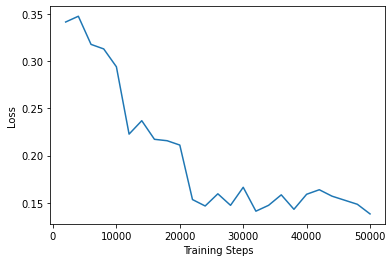

In [43]:
p = sns.lineplot( x=steps, y=loss)
p.set_xlabel("Training Steps")
p.set_ylabel("Loss")

Text(0, 0.5, 'Loss')

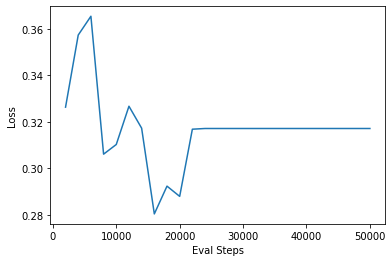

In [44]:
p = sns.lineplot(x=eval_steps, y=eval_loss)
p.set_xlabel("Eval Steps")
p.set_ylabel("Loss")

Text(0, 0.5, 'Loss')

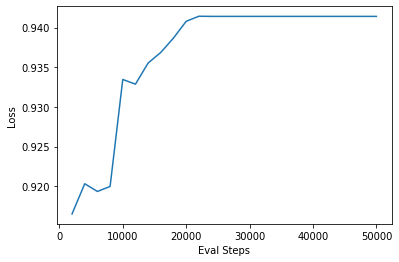

In [45]:
p = sns.lineplot(x=eval_steps, y=eval_accuracy)
p.set_xlabel("Eval Steps")
p.set_ylabel("Loss")

## Use Fine-tuned Model:

Load checkpoint:

In [7]:
model_tuned = RobertaForTokenClassification.from_pretrained("./results/checkpoint-final/")

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Set correct class labels:

In [4]:
label_names = dataset_train.features[f"ner_tags"].feature.names

id2label = {id : label for id, label in enumerate(label_names)}
label2id = {label: id for id, label in enumerate(label_names)}

model_tuned.config.id2label = id2label
model_tuned.config.label2id = label2id

NameError: name 'dataset_train' is not defined

In [5]:
model_tuned.config.id2label

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [7]:
text = "Für Richard Phillips Feynman war es immer wichtig in New York, die unanschaulichen Gesetzmäßigkeiten der Quantenphysik Laien und Studenten nahezubringen und verständlich zu machen."

inputs = tokenizer(
    text, 
    add_special_tokens=False, return_tensors="pt"
)

with torch.no_grad():
    logits = model_tuned(**inputs).logits

predicted_token_class_ids = logits.argmax(-1)

# Note that tokens are classified rather then input words which means that
# there might be more predicted token classes than words.
# Multiple token classes might account for the same word
predicted_tokens_classes = [model_tuned.config.id2label[t.item()] for t in predicted_token_class_ids[0]]
predicted_tokens_classes

['O',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [8]:
text = "In December 1903 in France the Royal Swedish Academy of Sciences awarded Pierre Curie, Marie Curie, and Henri Becquerel the Nobel Prize in Physics"

inputs = tokenizer(
    text, 
    add_special_tokens=False, return_tensors="pt"
)

with torch.no_grad():
    logits = model_tuned(**inputs).logits

predicted_token_class_ids = logits.argmax(-1)

# Note that tokens are classified rather then input words which means that
# there might be more predicted token classes than words.
# Multiple token classes might account for the same word
predicted_tokens_classes = [model_tuned.config.id2label[t.item()] for t in predicted_token_class_ids[0]]
predicted_tokens_classes

['O',
 'O',
 'O',
 'O',
 'B-LOC',
 'O',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'O',
 'B-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG']

## Upload to Huggingface

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_tuned.push_to_hub("roberta-ner-multilingual", use_temp_dir=True )

/home/julian/Documents/Workspace_Python/bloom-ner-multilingual/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:38: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='roberta-ner-multilingual' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  warnings.warn(
/home/julian/Documents/Workspace_Python/bloom-ner-multilingual/venv/lib/python3.10/site-packages/huggingface_hub/hf_api.py:681: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  warnings.warn(
Cloning https://huggingface.co/julian-schelb/roberta-ner-multilingual into local empty directory.
